In [131]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from cv2 import imread

In [133]:
# set seed for reproducibility 
SEED = 23998102

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [134]:
BASE_PATH = '/home/bermana/george_data/'

In [284]:
dataframe = pd.read_csv('/Volumes/pakistancv/Survey/all_images_with_owner_names_matched.csv')

#dataframe = pd.read_csv('all_images_with_owner_names_matched.csv')
#os.chdir(BASE_PATH)

# filter out dataframe rows that cannot be processed for quality reasons
index_drop = [i for i, row in dataframe.iterrows() if 
    #os.path.isfile(row['filepath']) or 
    row['match_cov_land_area_enum'] != 0 or
    row['garv'] == 0 or
    row['coveredarea'] == 0 or
    row['landarea'] == 0 or
    row['floors'] == 0
]

dataframe.drop(dataframe.index[index_drop], inplace=True)

print(str(len(dataframe)) + ' images of sufficient quality available')

1119 images of sufficient quality available


<AxesSubplot:xlabel='floors', ylabel='landarea'>

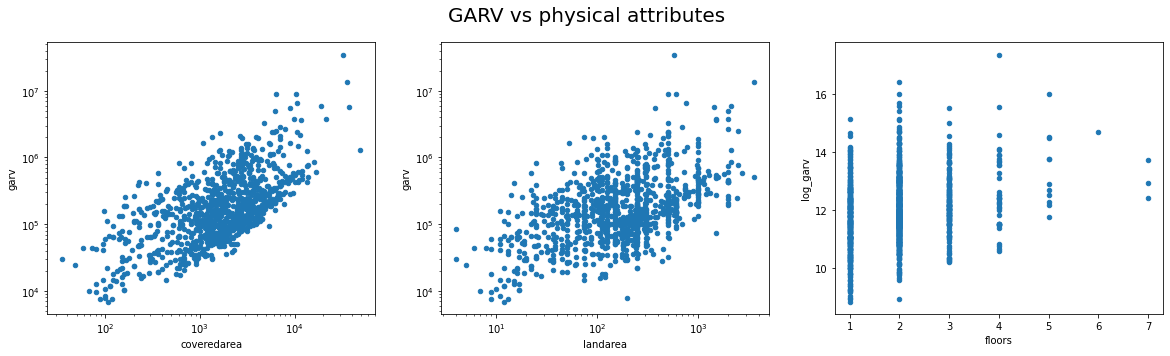

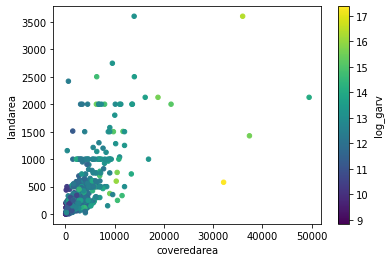

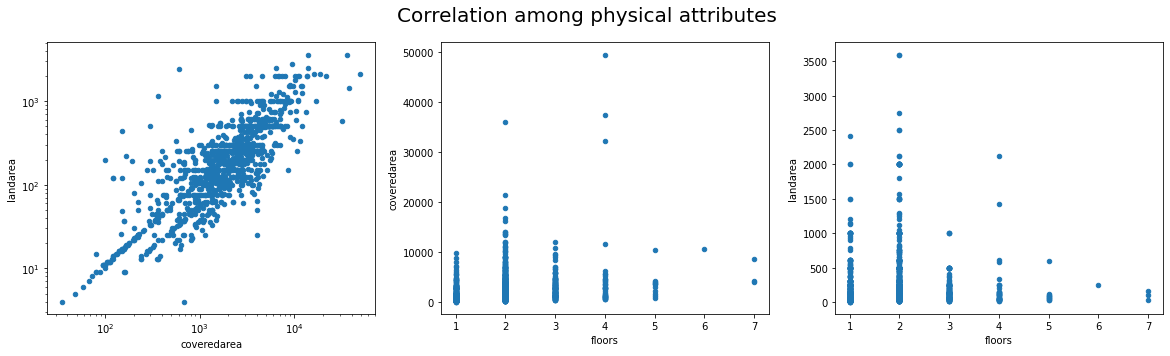

In [245]:
# relationships between GARV and physical attributes 
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig1.suptitle('GARV vs physical attributes', fontsize=20)

dataframe.plot.scatter(x='coveredarea', y='garv', loglog=True, ax=ax1[0])
dataframe.plot.scatter(x='landarea', y='garv', loglog=True, ax=ax1[1])
dataframe.plot.scatter(x='floors', y='log_garv', ax=ax1[2])

dataframe.plot.scatter(x='coveredarea', y='landarea', c='log_garv', colormap='viridis', sharex=False)

# relationships between physical attributes
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig2.suptitle('Correlation among physical attributes', fontsize=20)

dataframe.plot.scatter(x='coveredarea', y='landarea', loglog=True, ax=ax2[0])
dataframe.plot.scatter(x='floors', y='coveredarea', ax=ax2[1])
dataframe.plot.scatter(x='floors', y='landarea', ax=ax2[2])

In [285]:
# drop 1/3 of the medium area sample points to equalize datasets. As landarea and covered area of correlated,
# we approximiate with coveredarea since coveredarea is more correlated with garv.
dataframe_medium = dataframe[dataframe['covarea_category'] == 'Medium']
dataframe_medium = dataframe_medium.sample(frac=0.3333, random_state=SEED)

# append back in
dataframe = dataframe[dataframe['covarea_category'] != 'Medium']
dataframe = dataframe.append(dataframe_medium, ignore_index=True)

# randomly shuffle images before sorting into train/test 
dataframe = dataframe.sample(frac=1, random_state=SEED)

# check
print(dataframe['covarea_category'].value_counts())
print(dataframe['landarea_category'].value_counts())
print(dataframe['floors'].value_counts(sort=False))

Low       256
Medium    217
High      211
Name: covarea_category, dtype: int64
Medium    287
Low       234
High      163
Name: landarea_category, dtype: int64
1    207
2    366
3     80
4     22
5      8
7      1
Name: floors, dtype: int64


In [ ]:
class TileDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        tile = imread(root_dir + dataframe['filepath'])
        if transforms:
            tile = self.transforms(tile)
        return tile

In [ ]:
# define transforms
train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                       ])

In [ ]:
# split data into train/valid and test sets
TEST_RATIO = 0.2

n_total = len(dataframe)
n_train_valid = int(n_total * (1 - TEST_RATIO))

train_valid_data, test_data  = random_split(dataframe, [n_train_valid, n_total - n_train_valid])

In [ ]:
!nvidia-smi

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [ ]:
# set up model 
model_conv = torchvision.models.resnet50(pretrained=False)
num_filters = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_filters, 3)

model_conv = model_conv.to(device)

# params
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=0.00001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=500, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    pass
    

In [ ]:
def k_fold_validation(k=5):
    train_data = train_valid
    train_dataloader = DataLoader(TileDataset())
    model_conv, train_losses, val_losses, train_accs, val_accs = train_model(model_conv, criterion, optimizer,
                         scheduler, num_epochs=200)
    

In [ ]:
# train model


In [ ]:
# eval model
model_conv.eval() # set model to evaluate mode